<a href="https://colab.research.google.com/github/theysee/sberbank_reboot/blob/master/%D0%A8%D0%BA%D0%BE%D0%BB%D0%B0_DA_%D0%9F%D0%BE%D1%82%D0%BE%D0%BA_3_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6_%D1%81%D1%82%D1%80%D0%BE%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D0%B8_%D0%A1%D0%B5%D1%80%D0%B3%D0%B5%D0%B9_%D0%90%D1%80%D1%82%D0%B5%D0%B5%D0%B2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Суть Проекта в том, чтобы проанализировать продажи в крупной строительной компании.
Входные данные поступают в формах Excel. Формируются программой автоматически, а значит всегда постоянны. Некоторые столбцы для анализа продаж не нужны, поэтому я буду их удалять, чтобы не мешались.

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%matplotlib inline

In [2]:
# Если не сработает загрузка файлов, дальше есть загрузка в SQL.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Прочитал, что список файлов в Colab не получить, поэтому делаю руками.
!ls "/content/drive/My Drive/Эскроу"

'Анализ продаж строительной компании.gslides'   Застройщик_146.xls
 Застройщик_110.xls			        Застройщик_170.xls
 Застройщик_120.xls			        Застройщик_176.xls
 Застройщик_140.xls			        Застройщик_28.xls
 Застройщик_141.xls


In [0]:
# Функция для наведения красоты.
# Удаляем лишние данные, обрезаем сверху тех ячейки в Excel.
def pars(data_read):
  contract = data_read.iloc[5,6]
  contract = contract.split(' ')
  contract = contract[-3:-2]
  contract = contract[0]
  data_read.drop(data_read.columns[[0, 4, 5, 6, 7, 8, 9, 10, 11]], axis='columns', inplace=True)
  data_read.drop([0,1,2,3,4,5,6,7], inplace=True)
  data_read.columns = ['Date_open_escrow', 'Depo_summ', 'Date_pay']
  data_read['Date_open_escrow'] =  pd.to_datetime(data_read['Date_open_escrow']).dt.date
  data_read['Date_pay'] =  pd.to_datetime(data_read['Date_pay']).dt.date
  data_read['Contract'] = contract
  return data_read

In [5]:
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_110.xls')
df = pars(data_read)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_140.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_146.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_176.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_120.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_141.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_170.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_28.xls')
df = df.append(pars(data_read), ignore_index = True)
df.dropna(inplace=True)
df['Depo_summ'] = df['Depo_summ'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818 entries, 0 to 1845
Data columns (total 4 columns):
Date_open_escrow    1818 non-null object
Depo_summ           1818 non-null int64
Date_pay            1818 non-null object
Contract            1818 non-null object
dtypes: int64(1), object(3)
memory usage: 71.0+ KB


In [6]:
!pip install PyMySQL

     |████████████████████████████████| 51kB 1.5MB/s 


In [0]:
import pymysql
DB_HOST = '89.223.95.235'
DB_USER = 'student_12'
DB_USER_PASSWORD = 'student_12'
DB_NAME = 'student_12'
conn = pymysql.connect(DB_HOST, DB_USER, DB_USER_PASSWORD, DB_NAME)

In [8]:
pd.read_sql_query("show tables", conn)

,Tables_in_student_12
0,sales


In [0]:
#query = "DROP TABLE IF EXISTS Sales"
#conn.cursor().execute(query)
#conn.commit()

In [10]:
# По идее, ключ не нужен, но как SQL без ключа.
query = """
  CREATE TABLE IF NOT EXISTS Sales (
    Sales_id INT AUTO_INCREMENT PRIMARY KEY,
    Date_open_escrow DATETIME,
    Depo_summ NUMERIC,
    Date_pay DATETIME,
    Contract INT
    )
""" 

conn.cursor().execute(query)
conn.commit()

/usr/local/lib/python3.6/dist-packages/pymysql/cursors.py:170: Warning: (1050, "Table 'sales' already exists")
  result = self._query(query)


In [0]:
queries = []

for index, row in df.iterrows():
    querie = f'''INSERT INTO Sales (Date_open_escrow, Depo_summ, Date_pay, Contract) VALUES ('{row[0]}', '{row[1]}', '{row[2]}', '{row[3]}')'''
    queries.append(querie)

#for q in queries:
  #conn.cursor().execute(q)
#conn.commit()

In [21]:
# Если строк 1818, значит всё в порядке.
df = pd.read_sql_query('''SELECT * FROM Sales''', conn)
df['Date_pay'] =  pd.to_datetime(df['Date_pay']).dt.date
df['Date_open_escrow'] =  pd.to_datetime(df['Date_open_escrow']).dt.date
df

,Sales_id,Date_open_escrow,Depo_summ,Date_pay,Contract
0,1,2019-06-28,3048000.0,2019-09-30,110
1,2,2019-06-28,2048000.0,2019-08-31,110
2,3,2019-06-28,2448000.0,2019-08-31,110
3,4,2019-06-28,98000.0,2021-09-30,110
4,5,2019-06-28,3700000.0,2019-12-31,110
...,...,...,...,...,...
1813,1814,2020-01-30,3520000.0,2021-09-30,28
1814,1815,2020-02-04,5150000.0,2021-09-30,28
1815,1816,2020-01-30,3150000.0,2021-09-30,28
1816,1817,2020-01-31,4190000.0,2021-09-30,28


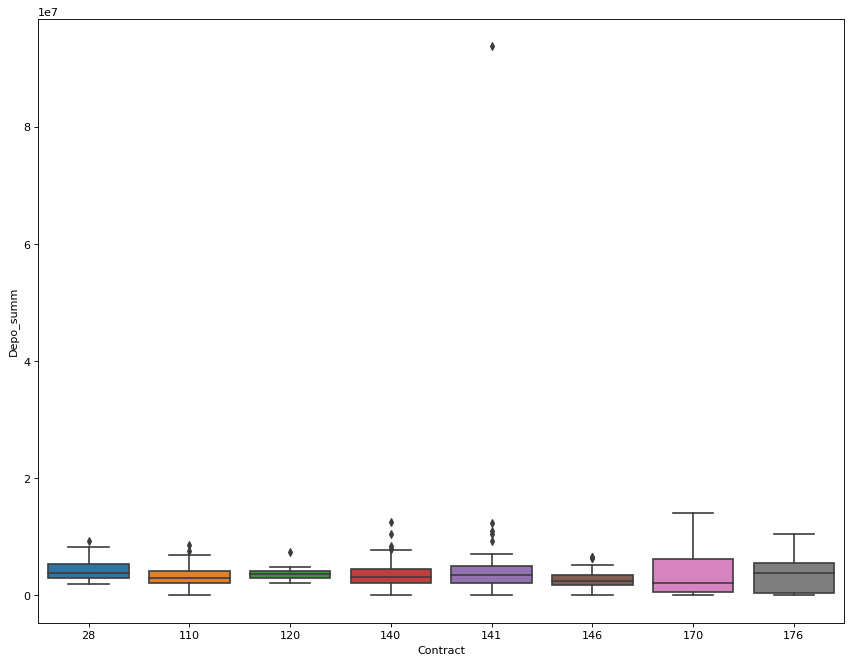

In [22]:
# Используем ящик, чтобы понять, какой вообще разброс цены.
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(x='Contract', y='Depo_summ', data=df, notch=False)
# Видим выброс. Это не ошибка, такая продажа действительно была.
plt.show()

In [23]:
# Та самая сумма.
df['Depo_summ'].max()

93782826.0

In [24]:
# Посмотрим статистику по Датафрейму
df.describe()

,Sales_id,Depo_summ,Contract
count,1818.000000,1.818000e+03,1818.000000
mean,909.500000,3.470487e+06,130.777228
std,524.955712,3.154061e+06,49.057146
min,1.000000,1.000000e+00,28.000000
25%,455.250000,1.987401e+06,110.000000
50%,909.500000,3.400000e+06,141.000000
75%,1363.750000,4.950000e+06,170.000000
max,1818.000000,9.378283e+07,176.000000


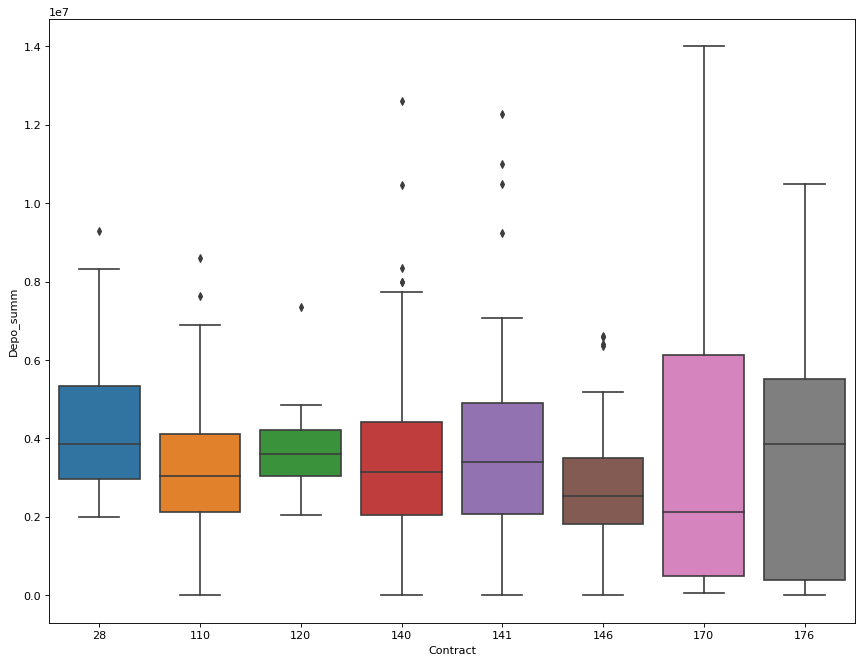

In [25]:
# Построим график без этого выброса.
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(x='Contract', y='Depo_summ', data=df[df['Depo_summ'] < df['Depo_summ'].max()], notch=False)
plt.show()

Компания работает в разных городах России. Проекты тоже разные и продаются с разной динамикой и успехом.
Выводы по графику:
Наиболее стабильный размер счета эскроу в договоре 120 и наиболее нестабильные в 170 и 176. С точки зрения бизнеса, стоит присмотреться к проектам, где продажи нестабильны.

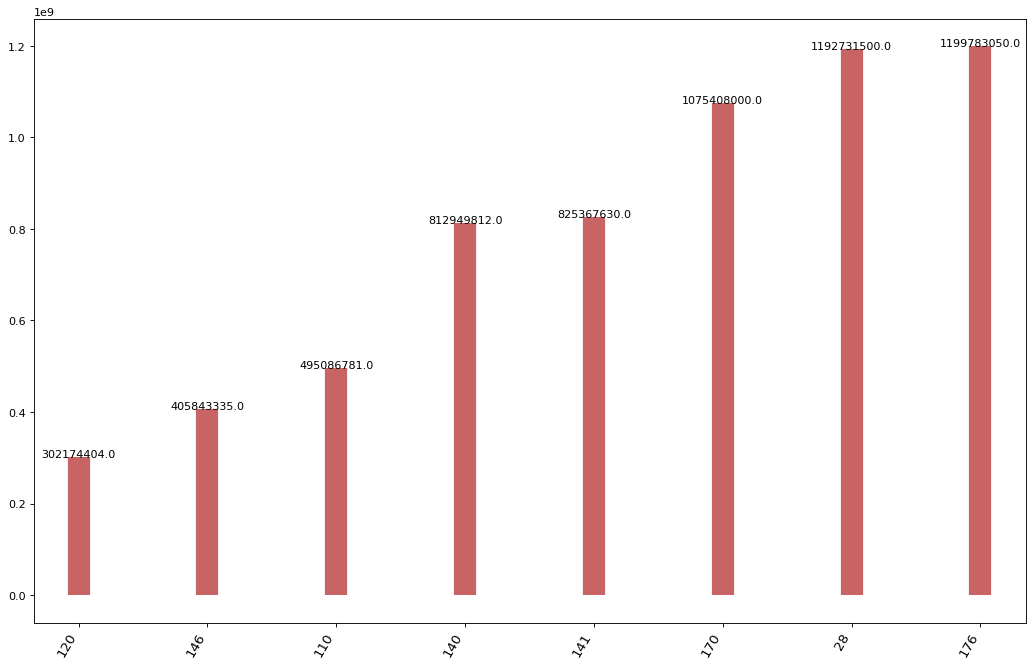

In [26]:
# Посмотрим на суммы продаж по договорам.
df1 = df.groupby('Contract').aggregate(sum)
df1.sort_values('Depo_summ', inplace=True)
df1.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=df1.index, ymin=0, ymax=df1.Depo_summ, color='firebrick', alpha=0.7, linewidth=20)
for i, Depo_summ in enumerate(df1.Depo_summ):
    ax.text(i, Depo_summ+1, round(Depo_summ, 1), horizontalalignment='center')
plt.xticks(df1.index, df1.Contract, rotation=60, horizontalalignment='right', fontsize=12)
plt.show()

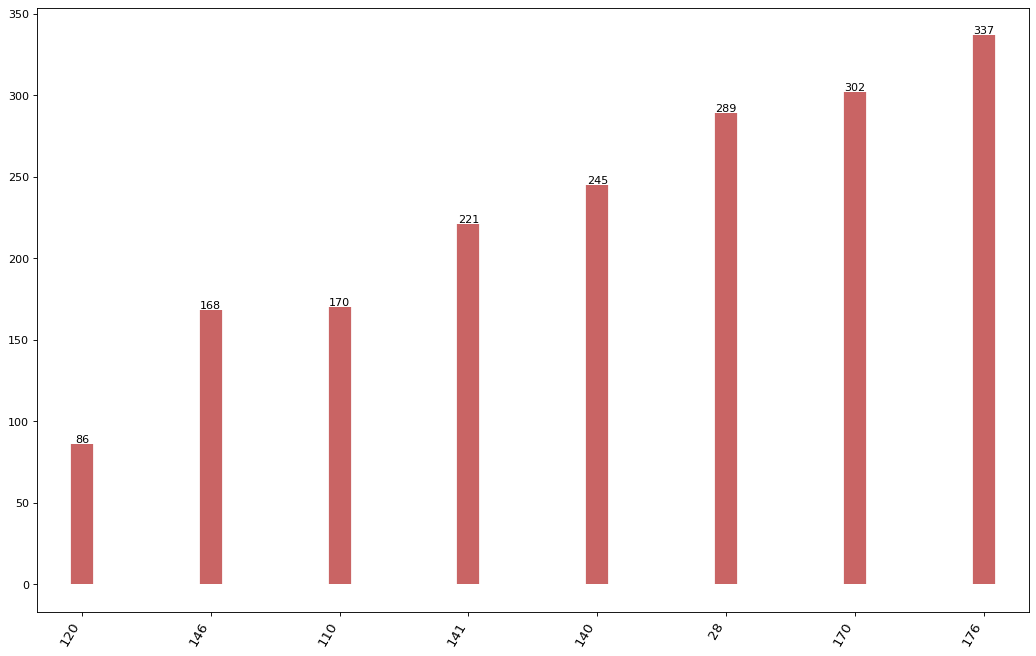

In [27]:
# А теперь на количество продаж по договорам.
df1 = df.groupby('Contract')['Depo_summ'].agg(['sum', 'count'])
df1.sort_values('count', inplace=True)
df1.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=df1.index, ymin=0, ymax=df1['count'], color='firebrick', alpha=0.7, linewidth=20)
for i, count in enumerate(df1['count']):
    ax.text(i, count+1, round(count, 1), horizontalalignment='center')
plt.xticks(df1.index, df1.Contract, rotation=60, horizontalalignment='right', fontsize=12)
plt.show()

Выводы:
Видим, что некоторые договоры не совпадают в последовательности между суммой на эскроу и количеством продаж.
Например, договор 28 и 141 при меньших продажах демонстрируют большие суммы на счетах.

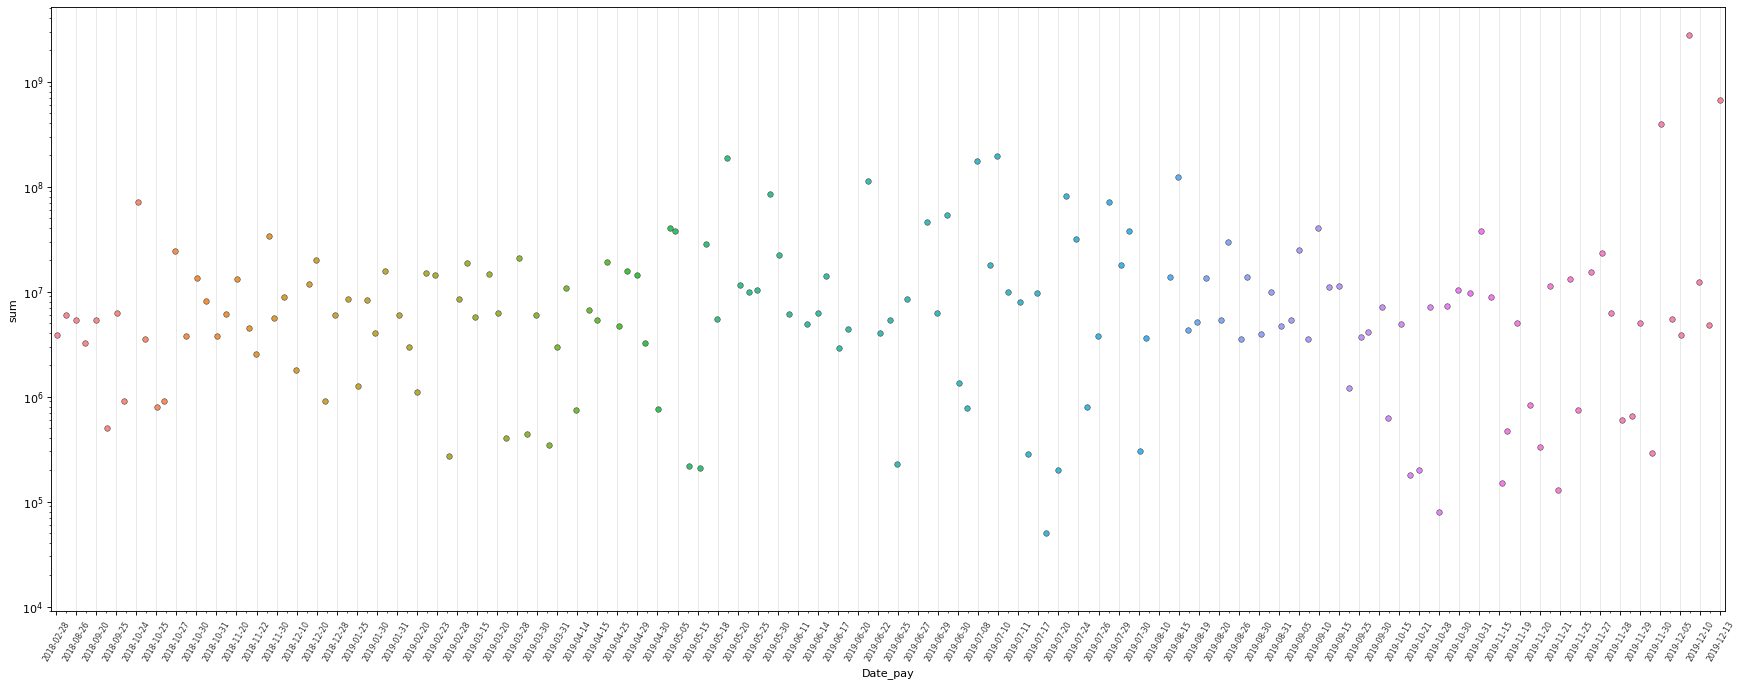

In [28]:
# Построим график продаж по договорам во времени. 
# Это дата ожидаемого внесения средств.
df1 = df.groupby(['Date_pay'])['Depo_summ'].agg(['sum'])
df1.sort_values('Date_pay', inplace=True)
df1.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(27,10), dpi= 80)    
sns.stripplot(df1['Date_pay'], df1['sum'], jitter=0.25, size=5, ax=ax, linewidth=.5)
plt.yscale('log')
plt.xticks(rotation=60, fontsize=7, alpha=.8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.grid(axis='x', alpha=.3)
plt.show()

Это даты обязательств по оплате. Т.е. покупатель квартиры должен в срок по оси х внести сумму по оси у на эскроу счет.
Таким образом мы можем видеть, что поступление средств на всём сроке примерно одинаковое, но в 2021 году с сентября по декабрь планируется поступление больших сумм. С учетом банковской специфики, можно предположить, что в это время нам следует готовиться к тому, что они выплатят кредит.

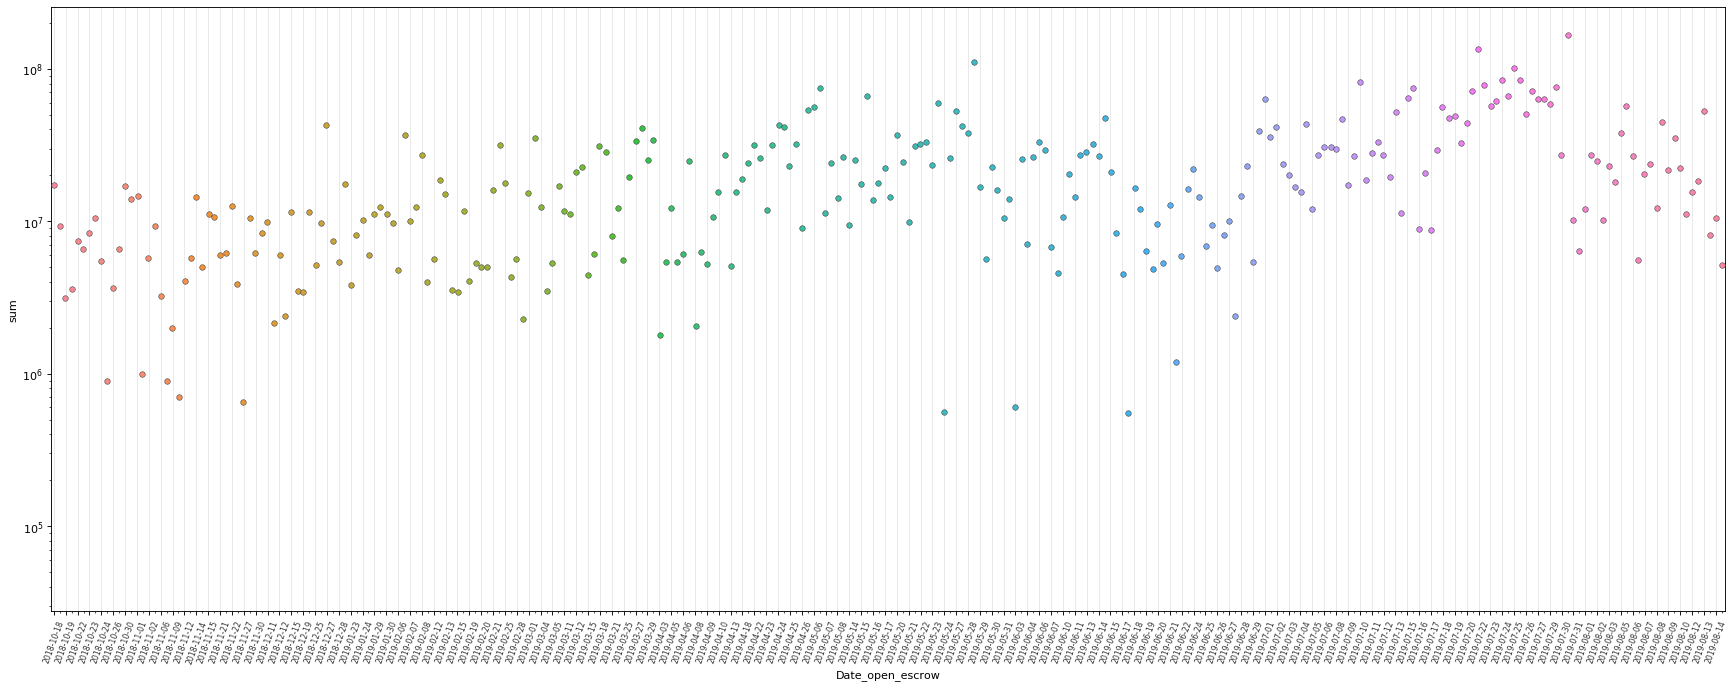

In [20]:
# Это даты открытия эскроу. Фактически, это даты заключения ДДУ, т.е покупки квартиры.
df1 = df.groupby(['Date_open_escrow'])['Depo_summ'].agg(['sum'])
df1.sort_values('Date_open_escrow', inplace=True)
df1.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(27,10), dpi= 80)    
sns.stripplot(df1['Date_open_escrow'], df1['sum'], jitter=0.1, size=5, ax=ax, linewidth=.5)
plt.yscale('log')
plt.xticks(rotation=70, fontsize=7, alpha=.8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.grid(axis='x', alpha=.3)
plt.show()

Это продажи по датам и сумме. Можно заметить тренд - пологий подъем продаж от начала графика до мая 2019, потом просадка до июня 2019, рост в июле и спад к августу. Вероятно влияние сезонности.
Можно заметить, что продажи в конце графика осуществляются на более крупные суммы.

В целом можно заключить, что в компании, в целом, стабильные продажи. Однако в конце тренд в минус, но динамика под Новый год должна была бы выровняться.